In [ ]:
# February 2024
# Text classifier using logistic regression, support vector machine, and xlm-roberta
# Violeta Berdejo-Espinola

In [1]:
import numpy as np
import pandas as pd
import os
import mpu

# read data

In [3]:
# y data

y_train = mpu.io.read('../data/y_train.pickle')
y_test = mpu.io.read('../data/y_test.pickle')

# baseline short text

X_train_cv = mpu.io.read('../data/X_train_cv.pickle')
X_test_cv = mpu.io.read('../data/X_test_cv.pickle')
X_train_tfidf = mpu.io.read('../data/X_train_tfidf.pickle')
X_test_tfidf = mpu.io.read('../data/X_test_tfidf.pickle')
embedding_train = mpu.io.read('../data/embedding_train.pickle')
embedding_test = mpu.io.read('../data/embedding_test.pickle')
gemma2_train = mpu.io.read('../data/gemma2_train.pickle')
gemma2_test = mpu.io.read('../data/gemma2_test.pickle')

# baseline long text

X_train_cv_long = mpu.io.read('../data/X_train_long_cv.pickle')
X_test_cv_long = mpu.io.read('../data/X_test_long_cv.pickle')
X_train_tfidf_long = mpu.io.read('../data/X_train_long_tfidf.pickle')
X_test_tfidf_long = mpu.io.read('../data/X_test_long_tfidf.pickle')
embedding_train_long = mpu.io.read('../data/embedding_train_long.pickle')
embedding_test_long = mpu.io.read('../data/embedding_test_long.pickle')

# resampled (only for short text)

X_rus_train_tfidf = mpu.io.read('../data/X_rus_train_tfidf.pickle')
y_rus_train_tfidf = mpu.io.read('../data/y_rus_train_tfidf.pickle')

X_ros_train_tfidf = mpu.io.read('../data/X_ros_train_tfidf.pickle')
y_ros_train_tfidf = mpu.io.read('../data/y_ros_train_tfidf.pickle')

X_ada_train_tfidf = mpu.io.read('../data/X_ada_train_tfidf.pickle')
y_ada_train_tfidf = mpu.io.read('../data/y_ada_train_tfidf.pickle')

X_rus_train_cv = mpu.io.read('../data/X_rus_train_cv.pickle')
y_rus_train_cv = mpu.io.read('../data/y_rus_train_cv.pickle')

X_ros_train_cv = mpu.io.read('../data/X_ros_train_cv.pickle')
y_ros_train_cv = mpu.io.read('../data/y_ros_train_cv.pickle')

X_ada_train_cv = mpu.io.read('../data/X_ada_train_cv.pickle')
y_ada_train_cv = mpu.io.read('../data/y_ada_train_cv.pickle')

embedding_train_ros = mpu.io.read('../data/x_emb_train_ros.pickle')
y_train_ros = mpu.io.read('../data/y_emb_train_ros.pickle')


In [ ]:
from collections import Counter

counter = Counter()

for x in y_test:
    counter[x] +=1
    
print(counter)

In [4]:
pos = mpu.io.read('../data/pos.pickle')
neg = mpu.io.read('../data/neg_complete.pickle')

x = pos + neg
y = [1] * len(pos) + [0] * len(neg)

# model training

In [11]:
from collections import namedtuple

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# weights for class penalty (weighted cross-entropy loss)

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 

print(weight_for_class_0, weight_for_class_1)

# instantiate models

logreg = LogisticRegression(solver='lbfgs', random_state=42)
svm = SVC(kernel='linear')
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42)
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True)
mlp = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',
                    learning_rate_init=0.001, solver='adam', random_state=42)
mlp_tuned = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(800), learning_rate='invscaling',
                    learning_rate_init=0.001, solver='sgd', random_state=42)
mlp_tuned_2 = MLPClassifier(activation='logistic', batch_size=128, hidden_layer_sizes=(5,), learning_rate='invscaling',
                            learning_rate_init=1, solver='sgd', random_state=42, max_iter=400)

# create cases

Case = namedtuple("Case", "name model X Y x y vector weighting length")

cases_baseline = [
    
    # cases with title abstract 
    
    Case(name='LR', model=logreg, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='None', length='title-abs'),
    
    Case(name='SVM', model=svm, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='None', length='title-abs'),
    
    Case(name='LR', model=logreg, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='None', length='title-abs'),
    
    Case(name='SVM', model=svm, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='None', length='title-abs'),
    
    Case(name='LR', model=logreg, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None', length='title-abs'),
    
    Case(name='SVM', model=svm, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None', length='title-abs'),
    
    Case(name='MLP', model=mlp, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting='None', length='title-abs'),
    
    Case(name='LR', model=logreg, X=gemma2_train, Y=y_train, x=gemma2_test, y=y_test, vector="gemma2", weighting='BAL', length='title-abs'),
    
    Case(name='SVM', model=svm, X=gemma2_train, Y=y_train, x=gemma2_test, y=y_test, vector="gemma2", weighting='BAL', length='title-abs'),
    
    # cases with title abstract and main text
    
    Case(name='LR', model=logreg, X=X_train_cv_long, Y=y_train, x=X_test_cv_long, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs-text'),
    
    Case(name="SVM", model=svm, X=X_train_cv_long, Y=y_train, x=X_test_cv_long, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs-text'),
    
    Case(name='LR', model=logreg, X=X_train_tfidf_long, Y=y_train, x=X_test_tfidf_long, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs-text'),
    
    Case(name="SVM", model=svm, X=X_train_tfidf_long, Y=y_train, x=X_test_tfidf_long, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs-text'),
    
    Case(name='LR', model=logreg, X=embedding_train_long, Y=y_train, x=embedding_test_long, y=y_test, vector="embedding", weighting="BAL", length='title-abs-text'),
    
    Case(name='SVM', model=svm, X=embedding_train_long, Y=y_train, x=embedding_test_long, y=y_test, vector="embedding", weighting="BAL", length='title-abs-text')
    
    # Case(name='LR', model=logreg_weight, X=gamma2_train_long, Y=y_train, x=gamma2_test_long, y=y_test, vector="embedding", weighting='BAL', length='title-abs-text'),
    
    # Case(name='SVM', model=svm_weight, X=gamma2_train_long, Y=y_train, x=gamma2_test_long, y=y_test, vector="embedding", weighting='BAL', length='title-abs-text')
]

cases_weighted = [
    
    # cases with title abstract 
    
    Case(name='LR', model=logreg_weight, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs'),
    
    Case(name="SVM", model=svm_weight, X=X_train_cv, Y=y_train, x=X_test_cv, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs'),
    
    Case(name='LR', model=logreg_weight, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs'),
    
    Case(name="SVM", model=svm_weight, X=X_train_tfidf, Y=y_train, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs'),
    
    Case(name='LR', model=logreg_weight, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting="BAL", length='title-abs'),
    
    Case(name='SVM', model=svm_weight, X=embedding_train, Y=y_train, x=embedding_test, y=y_test, vector="embedding", weighting="BAL", length='title-abs'),
    
    Case(name='LR', model=logreg_weight, X=gemma2_train, Y=y_train, x=gemma2_test, y=y_test, vector="gemma2", weighting='BAL', length='title-abs'),
    
    Case(name='SVM', model=svm_weight, X=gemma2_train, Y=y_train, x=gemma2_test, y=y_test, vector="gemma2", weighting='BAL', length='title-abs'),
    
    # cases with title abstract and main text
    
    Case(name='LR', model=logreg_weight, X=X_train_cv_long, Y=y_train, x=X_test_cv_long, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs-text'),
    
    Case(name="SVM", model=svm_weight, X=X_train_cv_long, Y=y_train, x=X_test_cv_long, y=y_test, vector="word_frequency", weighting='BAL', length='title-abs-text'),
    
    Case(name='LR', model=logreg_weight, X=X_train_tfidf_long, Y=y_train, x=X_test_tfidf_long, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs-text'),
    
    Case(name="SVM", model=svm_weight, X=X_train_tfidf_long, Y=y_train, x=X_test_tfidf_long, y=y_test, vector="TF-IDF", weighting='BAL', length='title-abs-text'),
    
    Case(name='LR', model=logreg_weight, X=embedding_train_long, Y=y_train, x=embedding_test_long, y=y_test, vector="embedding", weighting="BAL", length='title-abs-text'),
    
    Case(name='SVM', model=svm_weight, X=embedding_train_long, Y=y_train, x=embedding_test_long, y=y_test, vector="embedding", weighting="BAL", length='title-abs-text')
    
    # Case(name='LR', model=logreg_weight, X=gamma2_train_long, Y=y_train, x=gamma2_test_long, y=y_test, vector="embedding", weighting='BAL'),
    
    # Case(name='SVM', model=svm_weight, X=gamma2_train_long, Y=y_train, x=gamma2_test_long, y=y_test, vector="embedding", weighting='BAL')
]

cases_resampled_tfidf = [ # cases with title abstract 
                         
    Case(name="LR", model=logreg, X=X_rus_train_tfidf, Y=y_rus_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='RUS', length='title-abs'),
     
    Case(name="LR", model=logreg, X=X_ros_train_tfidf, Y=y_ros_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ROS', length='title-abs'),
    
    Case(name="LR", model=logreg, X=X_ada_train_tfidf, Y=y_ada_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ADA', length='title-abs'),
    
    Case(name="SVM", model=svm, X=X_rus_train_tfidf, Y=y_rus_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='RUS', length='title-abs'),
    
    Case(name="SVM", model=svm, X=X_ros_train_tfidf, Y=y_ros_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ROS', length='title-abs'),
    
    Case(name="SVM", model=svm, X=X_ada_train_tfidf, Y=y_ada_train_tfidf, x=X_test_tfidf, y=y_test, vector="TF-IDF", weighting='ADA', length='title-abs')
]

cases_resampled_cv = [ # cases with title abstract 
                      
    Case(name="LR", model=logreg, X=X_rus_train_cv, Y=y_rus_train_cv, x=X_test_cv, y=y_test,  vector="word_frequency", weighting='RUS', length='title-abs'),
    
    Case(name="LR", model=logreg, X=X_ros_train_cv, Y=y_ros_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ROS', length='title-abs'),
    
    Case(name="LR", model=logreg, X=X_ada_train_cv, Y=y_ada_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ADA', length='title-abs'),
    
    Case(name="SVM", model=svm, X=X_rus_train_cv, Y=y_rus_train_cv, x=X_test_cv, y=y_test,  vector="word_frequency", weighting='RUS', length='title-abs'),   
    
    Case(name="SVM", model=svm, X=X_ros_train_cv, Y=y_ros_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ROS', length='title-abs'),
        
    Case(name="SVM", model=svm, X=X_ada_train_cv, Y=y_ada_train_cv, x=X_test_cv, y=y_test, vector="word_frequency", weighting='ADA', length='title-abs')
]

cases_resampled_embedding = [ # cases with title abstract 
                             
    Case(name='LR', model=logreg, X=embedding_train_ros, Y=y_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS', length='title-abs'),
    
    Case(name='MLP', model=mlp, X=embedding_train_ros, Y=y_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS', length='title-abs'),
    
    Case(name='MLP-TUNED', model=mlp_tuned, X=embedding_train_ros, Y=y_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS', length='title-abs'),
    
    Case(name='MLP-TUNED-2', model=mlp_tuned_2, X=embedding_train_ros, Y=y_train_ros, x=embedding_test, y=y_test, vector='embbeding', weighting='ROS', length='title-abs')
]

0.506253782529756 40.475806451612904


In [12]:
# function to fit models, make predictions with train and test sets

from sklearn.metrics import f1_score, recall_score, precision_score

def get_scores(cases):
    # create lists to store information of each model and their prediction scores for train and test set
    scores_list = []
    models_list = []

    for case in cases:
        
        # fit models and make predictions
        model = case.model.fit(case.X, case.Y)
        
        if case.name in ['LR','SVM', 'MLP', 'MLP-TUNED', 'MLP_TUNED_2']:
            
            y_train_pred = cross_val_predict(case.model, case.X, case.Y, cv=StratifiedKFold(10), method='predict')
            y_test_pred = model.predict(case.x)
        
        else:
            
            y_test_pred = model.predict(case.x)
            

        # save fitted model
        models = {
            "name": f'{case.name}_{case.weighting}_{case.vector}',
            "model": model,
            
        }
        
        # save scores from predicitons
        scores = {
            'Classifier': case.name,
            'Numeric_rep': case.vector,
            'Weighting': case.weighting,
            'Text_length': case.length,
            'Instances': len(case.Y),
            'F1_tr': round(f1_score(case.Y, y_train_pred), 3),
            'F1_ts': round(f1_score(case.y, y_test_pred), 3),
            'Precision_tr': round(precision_score(case.Y, y_train_pred), 3),
            'Precision_ts': round(precision_score(case.y, y_test_pred), 3),
            'Recall_tr': round(recall_score(case.Y, y_train_pred), 3),
            'Recall_ts': round(recall_score(case.y, y_test_pred), 3)
        }
        
        # store each model's dict and prediciton scores' dict in a list
        models_list.append(models)
        scores_list.append(scores)
        
    return models_list, scores_list

In [13]:
# fit models and make predictions

models_baseline, scores_baseline = get_scores(cases_baseline)
models_weighted, scores_weighted = get_scores(cases_weighted)
models_resampled_tfidf, scores_resampled_tfidf = get_scores(cases_resampled_tfidf)
models_resampled_cv, scores_resampled_cv = get_scores(cases_resampled_cv)
models_resampled_embedding, scores_resampled_embedding = get_scores(cases_resampled_embedding)

df1 = pd.DataFrame(scores_baseline)
df2 = pd.DataFrame(scores_weighted)
df3 = pd.DataFrame(scores_resampled_tfidf)
df4 = pd.DataFrame(scores_resampled_cv)
df5 = pd.DataFrame(scores_resampled_embedding)

results =  pd.concat([df1,df2,df3,df4,df5])
# results

/Users/uqvberde/Projects/classifier_spanish/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Projects/classifier_spanish/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/uqvberde/Projects/classifier_spanish/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [15]:
df2

,Classifier,Numeric_rep,Weighting,Instances,F1_tr,F1_ts,Precision_tr,Precision_ts,Recall_tr,Recall_ts
0,LR,word_frequency,BAL,4015,0.269,0.211,0.500,0.333,0.184,0.154
1,SVM,word_frequency,BAL,4015,0.136,0.133,0.400,0.500,0.082,0.077
2,LR,TF-IDF,BAL,4015,0.123,0.200,0.250,0.286,0.082,0.154
3,SVM,TF-IDF,BAL,4015,0.111,0.133,0.600,0.500,0.061,0.077
4,LR,embedding,BAL,4015,0.168,0.240,0.098,0.138,0.592,0.923
5,SVM,embedding,BAL,4015,0.197,0.286,0.128,0.180,0.429,0.692
6,LR,gemma2,BAL,4015,0.325,0.333,0.419,0.600,0.265,0.231
7,SVM,gemma2,BAL,4015,0.290,0.333,0.500,0.600,0.204,0.231
8,LR,word_frequency,BAL,4015,0.156,0.333,0.333,0.600,0.102,0.231
9,SVM,word_frequency,BAL,4015,0.190,0.200,0.429,0.286,0.122,0.154


In [14]:
res = results.sort_values(by='Recall_ts', ascending=False).reset_index(drop=True)
# res.to_csv('../results/logreg_svm_mlp_results.csv')
res

,Classifier,Numeric_rep,Weighting,Instances,F1_tr,F1_ts,Precision_tr,Precision_ts,Recall_tr,Recall_ts
0,MLP-TUNED-2,embbeding,ROS,7932,0.560,0.267,0.753,0.156,0.446,0.923
1,LR,embedding,BAL,4015,0.168,0.240,0.098,0.138,0.592,0.923
2,MLP-TUNED,embbeding,ROS,7932,0.560,0.070,0.753,0.036,0.446,0.923
3,LR,embedding_long,BAL,4015,0.168,0.240,0.098,0.138,0.592,0.923
4,LR,embbeding,ROS,7932,0.971,0.262,0.943,0.155,1.000,0.846
5,SVM,TF-IDF,RUS,98,0.766,0.079,0.800,0.042,0.735,0.692
6,LR,TF-IDF,RUS,98,0.745,0.080,0.778,0.042,0.714,0.692
7,SVM,embedding,BAL,4015,0.197,0.286,0.128,0.180,0.429,0.692
8,SVM,embedding,BAL,4015,0.197,0.286,0.128,0.180,0.429,0.692
9,SVM,word_frequency,RUS,98,0.659,0.069,0.818,0.037,0.551,0.538


# best performing models

# log reg

In [66]:
# predict probabilities and calculate model loss
# log_likelihood = y_test*np.log(y_pred) + (1-y_test)*np.log(1-y_pred)

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

model = logreg_weight.fit(embedding_train, y_train)

# training set
y_pred_tr = model.predict_proba(embedding_train) # predict_proba returns probabilities of a classification label
logloss_tr = log_loss(y_train, y_pred_tr)        # calculate loss of y_pred

# test set
y_pred_ts = model.predict_proba(embedding_test)  
logloss_ts = log_loss(y_test, y_pred_ts)

print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
print(f'confusion matrix test set:\n{confusion_matrix(y_test, model.predict(embedding_test))}') 

# (tn, fp, fn, tp)
#true negatives, false positives
#false negatives, true positives

loss training set: 0.1897658868436411, 
loss test set 0.2029458388129216
confusion matrix test set:
[[916  75]
 [  1  12]]


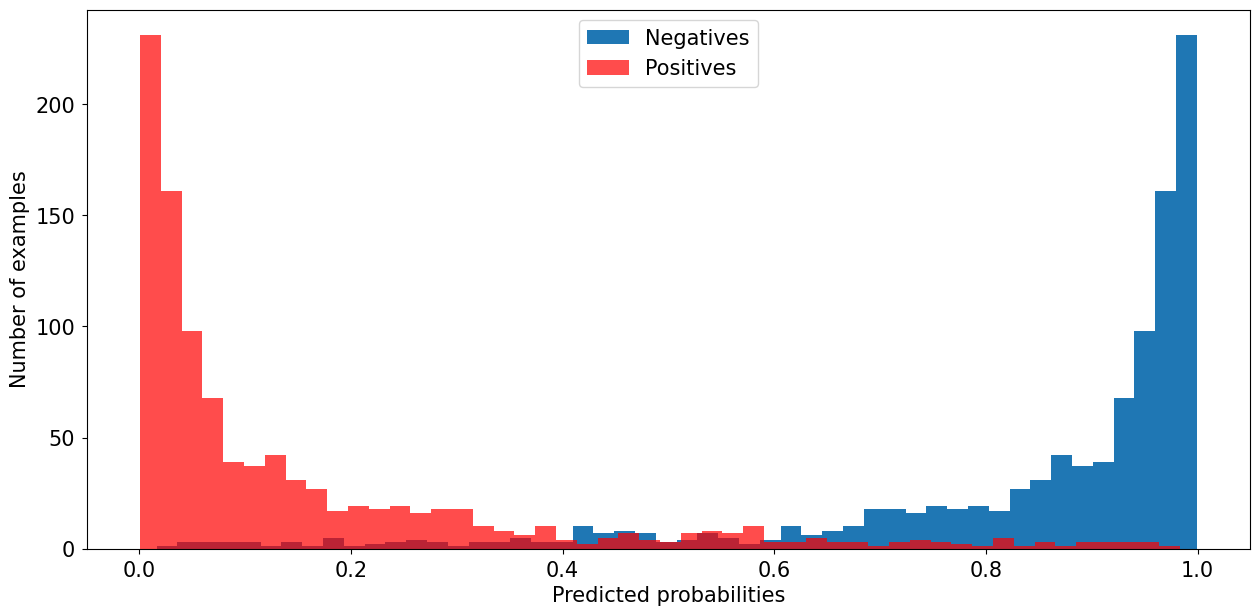

<Figure size 640x480 with 0 Axes>

In [67]:
# plot predicted probabilities

import matplotlib.pyplot as plt

y_pred_ts_p = model.predict_proba(embedding_test)[:,1] # subset class of interest --> 1d array
y_pred_ts_n = model.predict_proba(embedding_test)[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=50, label='Negatives')
plt.hist(y_pred_ts_p, bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show() 
# plt.savefig('../results/logreg_svm_mlp/predicted_proba_logreg_ts.png', dpi=800)

# mlp 

In [57]:
model = mlp_tuned_2.fit(embedding_train_ros, y_train_ros)

# training set loss
y_pred = model.predict_proba(embedding_train_ros)
logloss_tr = log_loss(y_train_ros, y_pred)

# test set loss
y_pred = model.predict_proba(embedding_test)
logloss_ts = log_loss(y_test, y_pred)

print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
print(f'confusion matrix test set:\n{confusion_matrix(y_test, model.predict(embedding_test))}')

loss training set: 0.12234181997139053, 
loss test set 0.16601314778513873
confusion matrix test set:
[[926  65]
 [  1  12]]


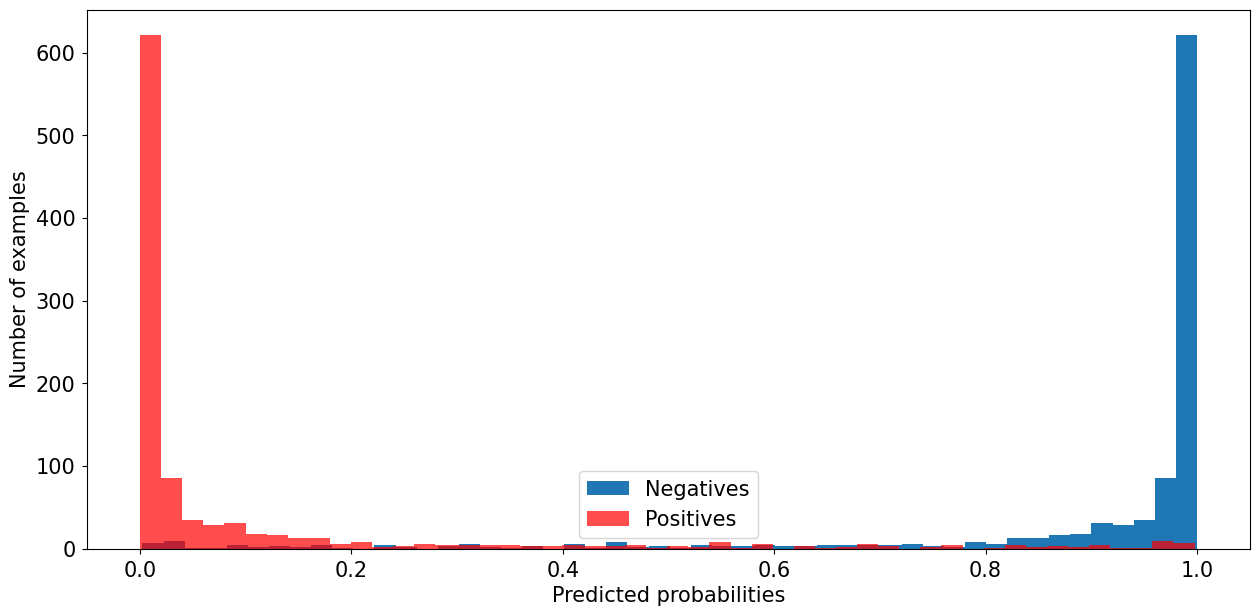

<Figure size 640x480 with 0 Axes>

In [61]:
# plot predicted probabilities

import matplotlib.pyplot as plt

y_pred_ts_p = model.predict_proba(embedding_test)[:,1] # subset class of interest --> 1d array
y_pred_ts_n = model.predict_proba(embedding_test)[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=50, label='Negatives')
plt.hist(y_pred_ts_p, bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show() 
# plt.savefig('../results/logreg_svm_mlp/predicted_proba_mlp_tuned_ts.png', dpi=800)

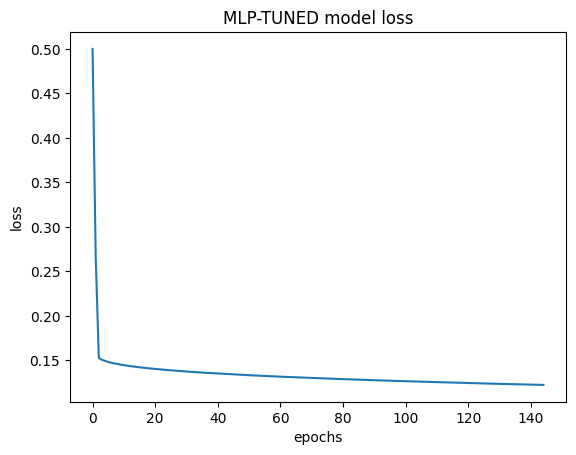

In [68]:
# calculate model loss - MLP TUNED

loss_values = mlp_tuned_2.loss_curve_

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('MLP-TUNED model loss')

plt.savefig('../results/logreg_svm_mlp/loss_mlp_tuned.png', dpi=800)

# error analysis

In [107]:
# log reg

dat_text = pd.read_csv('../datasets/x_test.csv', header=None)
dat_pred_label = pd.DataFrame(y_pred_ts, columns=['neg_label', 'pos_label'])
dat_pred_label['y_true'] = y_test

# assign predicted labels to examples

def get_prediction_label(row):
    if row["y_true"] == 0:
        return 'fp' if row['neg_label'] < 0.5 else 'tn'
    else:
        return 'tp' if row['pos_label'] > 0.5 else 'fn'

dat_pred_label['prediction_label'] = dat_pred_label.apply(get_prediction_label, axis=1)

dat_pred_label = dat_pred_label.merge(dat_text, left_index=True, right_index=True)
dat_pred_label.to_csv('../results/logreg_svm_mlp/error_analysis_predictions_with_tetx.csv')

# fp_examples = dat_pred_label[dat_pred_label['prediction_label'] == 'fp']
# fp_examples


In [88]:
len(mlp_tuned_2.coefs_[0])

512

# roc auc

In [72]:
# function to predict probabilities, compute auc score and roc curve 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_auc_roc(estimator, x_train, y_train, x_test, y_test):
    best_model = estimator.fit(x_train, y_train)
    pred_prob = best_model.predict_proba(x_test)
    y_pred = best_model.predict(x_test)
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    
    return auc_score, fpr, tpr, pred_prob, y_pred

# roc curve for tpr = fpr 

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_lr_weight, fpr_lr_weight, tpr_lr_weight, y_pred_proba_lr_weight, y_pred_lr_weight= get_auc_roc(logreg_weight, embedding_train, y_train, embedding_test, y_test)
auc_mlp_tuned, fpr_mlp_tuned, tpr_mlp_tuned, y_pred_proba_tuned, y_pred_mlp_tuned = get_auc_roc(mlp_tuned_2, embedding_train_ros, y_train_ros, embedding_test, y_test)
auc_lr_ovsmpld, fpr_lr_ovsmpld, tpr_lr_ovsmpld, y_pred_proba_lr_ovsmpld, y_pred_lr_ovsmpld = get_auc_roc(logreg, embedding_train_ros, y_train_ros, embedding_test, y_test)
auc_svm_weight, fpr_svm_weight, tpr_svm_weight, y_pred_proba_svm_weight, y_pred_svm_weight = get_auc_roc(svm_weight, embedding_train, y_train, embedding_test, y_test)

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_14769/46738959.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


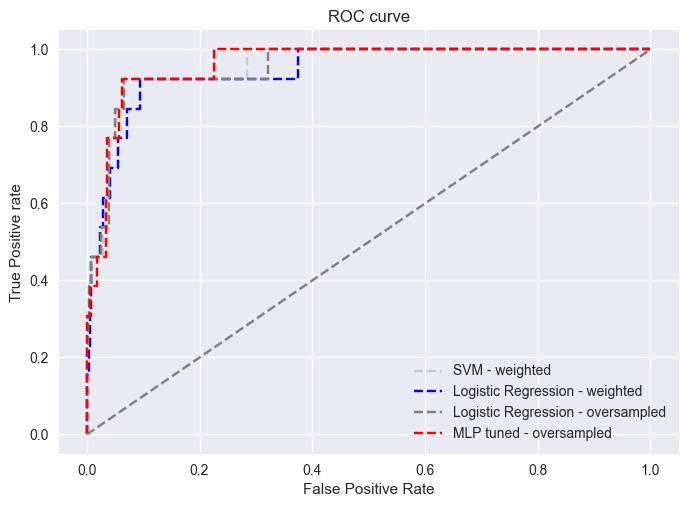

In [85]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr_weight, tpr_lr_weight, linestyle='--',color='#bbca', label='SVM - weighted')
plt.plot(fpr_svm_weight, tpr_svm_weight, linestyle='--',color='blue', label='Logistic Regression - weighted')
plt.plot(fpr_lr_ovsmpld, tpr_lr_ovsmpld, linestyle='--',color='gray', label='Logistic Regression - oversampled')
plt.plot(fpr_mlp_tuned, tpr_mlp_tuned, linestyle='--',color='red', label='MLP tuned - oversampled')

plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('../results/logreg_svm_mlp/ROC.png',dpi=800)
plt.show();

In [ ]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    
    return cm

cm1 = create_confusion_matrix(y_test, y_pred_lr_weight)
cm2 = create_confusion_matrix(y_test, y_pred_svm_weight)
cm3 = create_confusion_matrix(y_test, y_pred_lr_ovr)
cm4 = create_confusion_matrix(y_test, y_pred_lr_weight)

cm = pd.concat([cm1,cm2,cm3,cm4])

cm

#true negatives, false positives
#false negatives, true positives